In [104]:
# Standard imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import csv
from sklearn.ensemble import AdaBoostClassifier
np.random.seed(0) #staring random seed
from sklearn import linear_model

In [105]:
# Various utility functions
def shuffle(dframe, n = 1, axis = 0):
    dframe = dframe.copy()
    for x in range(n):
        dframe.apply(np.random.shuffle, axis = axis)
    return dframe

In [106]:
# read in the dataset
df = pd.read_csv('csvfiles/train.csv', header = 0)
test_df = pd.read_csv('csvfiles/test.csv', header = 0)

In [107]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [108]:
#Drop unused data
df = df.drop(['Ticket', 'Cabin'], axis = 1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis = 1)


# I forgot to drop the name column
df = df.drop('Name', axis  = 1)
test_df = test_df.drop('Name', axis = 1)



In [109]:
# Creation of new feature - family size
df['Family'] = df.SibSp + df.Parch
test_df['Family'] = test_df.SibSp + df.Parch

In [110]:
df = shuffle(df)

length = df.shape[0]

In [111]:
#create gender variable
df['Gender'] = df.Sex.map({'male': 0, 'female': 1})
test_df['Gender'] = test_df.Sex.map({'male': 0, 'female': 1})

In [112]:
df = df.drop('Sex', axis = 1)
test_df = test_df.drop('Sex', axis = 1)

In [113]:
# Graphic- where did people embark?
embarkations = df.groupby('Embarked')
embarkations.aggregate(np.size)['PassengerId']

Embarked
C    168
Q     77
S    644
Name: PassengerId, dtype: int64

In [114]:
#What proportion of passengers survived from each port of embarkation?
embarkations.aggregate(np.sum)['Survived'] / embarkations.aggregate(np.size)['PassengerId']

Embarked
C    0.553571
Q    0.389610
S    0.336957
dtype: float64

In [115]:
# Data says that ppl with missing embarkation survived - maybe fill with C
df.Embarked = df.Embarked.fillna('C')
test_df.Embarked = test_df.Embarked.fillna('C')

In [116]:
#Replace Embarked data as numeric - C = 0, Q = 1, S = 2
df.Embarked = df.Embarked.map({'C': 0, 'Q': 1, 'S': 2}).astype(np.int)
test_df.Embarked = test_df.Embarked.map({'C': 0, 'Q': 1, 'S': 2}).astype(np.int)

In [117]:
test_df.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Embarked,Family,Gender
0,892,3,34.5,0,0,7.8292,1,0.0,0
1,893,3,47.0,1,0,7.0000,2,1.0,1
2,894,2,62.0,0,0,9.6875,1,0.0,0
3,895,3,27.0,0,0,8.6625,2,0.0,0
4,896,3,22.0,1,1,12.2875,2,1.0,1


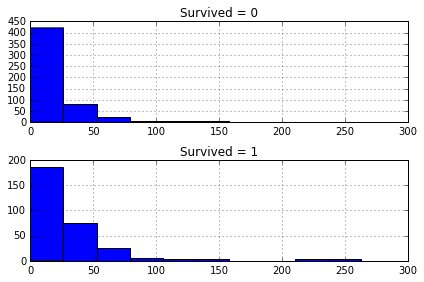

In [118]:
# What does the distribution of fare vs survival look like?
plt.figure(1)
for x in (0,1):
    plt.subplot(2,1,x + 1)
    fig = df.Fare[df.Survived == x & (df.Fare < df.Fare.quantile(q = .75))].hist()
    fig.set_title("Survived = {0}".format(x))
    plt.tight_layout()

In [119]:
# What are counts of survival by class?
survival_by_class = df.groupby('Pclass').aggregate(np.sum)
survival_by_class['Survived']

Pclass
1    136
2     87
3    119
Name: Survived, dtype: int64

It looks like people in first class survived more in total numbers.  I expect there to be significantly fewer people there as well.

In [120]:
survival_by_class_proportions = df.groupby('Pclass').aggregate(np.mean)
survival_by_class_proportions.Survived

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

It looks like people in first class had more than double the survival rate of people in third class. Second class was about double the rate of third class as well.  We might predict ppl in second class to survive.

In [121]:
# What does survival look like by gender?
survival_by_gender = df.groupby('Gender').aggregate(np.mean)
survival_by_gender.Survived

Gender
0    0.188908
1    0.742038
Name: Survived, dtype: float64

Men survived about 19% of the time, where women survived about 74% of the time.  It really goes to show, women and children first.  Which brings me to the next question, what does survival look like when considering age?

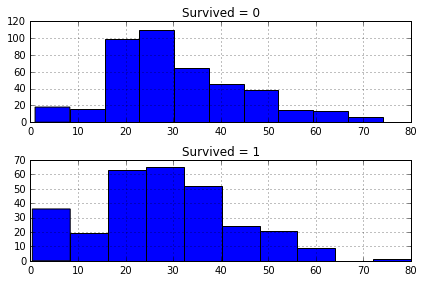

In [122]:
# What does the distribution of age vs survival look like?
plt.figure(1)
for x in (0,1):
    plt.subplot(2,1,x + 1)
    fig = df.Age.dropna()[df.Survived == x].hist()
    fig.set_title("Survived = {0}".format(x))
    plt.tight_layout()

The shapes look pretty similar, but it looks like more children and adults in their 30s and 40s survived proportionally than the rest of the population.

In [123]:
# Age IQR for the dead
dead_ages = [df.Age.dropna()[df.Survived == 0].quantile( q =.25), df.Age.dropna()[df.Survived == 0].median(), \
             df.Age.dropna()[df.Survived == 0].quantile(q = .75)]
dead_ages

[21.0, 28.0, 39.0]

In [124]:
# Age IQR for the dead
living = [df.Age.dropna()[df.Survived == 1].quantile( q =.25), df.Age.dropna()[df.Survived ==1].median(), \
             df.Age.dropna()[df.Survived == 1].quantile(q = .75)]
living

[19.0, 28.0, 36.0]

The living are on average about 2 to 3 years younger than the dead. Hopefully an SVM classifier picks that up.

In [125]:
# How about gender and class effect on survival
df.groupby(['Gender', 'Pclass']).aggregate(np.mean).Survived

Gender  Pclass
0       1         0.368852
        2         0.157407
        3         0.135447
1       1         0.968085
        2         0.921053
        3         0.500000
Name: Survived, dtype: float64

Men in the upper class still did not have a good chance for survival.

In [126]:
# Feature normalization
df.Age = (df.Age - df.Age.mean())/df.Age.std()
df.Fare = (df.Fare - df.Fare.mean()) / df.Fare.std()

test_df.Age = (test_df.Age - test_df.Age.mean())/test_df.Age.std()
test_df.Fare = (test_df.Fare - test_df.Fare.mean()) / test_df.Fare.std()

In [127]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Family', 'Gender'],
      dtype='object')

In [128]:
test_df.columns

Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'Family', 'Gender'],
      dtype='object')

In [134]:
# Fill in misisng age data - age of person is median of group in same class and gender
import itertools
age_by_class_gender = df.dropna().groupby(['Pclass', 'Gender']).aggregate(np.median).reset_index()
pclasses = (1,2,3)
genders = (0,1)
for (a,b) in itertools.product(pclasses, genders):
   new_age = age_by_class_gender[(age_by_class_gender.Pclass == a) & (age_by_class_gender.Gender == b)].Age.median()
   df.Age[(df.Gender == b) & (df.Pclass == a)] = new_age

1 0 0.7091098505909467
1 1 0.36491125366760807
2 0 0.02071265674426938
2 1 -0.11696678202506608
3 0 -0.3234859401790693


c:\Users\ANPitzer\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3 1 -0.5644249580254064


In [141]:
# Do the same with the test_df
age_by_class_gender = test_df.dropna().groupby(['Pclass', 'Gender']).aggregate(np.median).reset_index()
for (a,b) in itertools.product(pclasses, genders):
   new_age = age_by_class_gender[(age_by_class_gender.Pclass == a) & (age_by_class_gender.Gender == b)].Age.median()
   test_df.Age[(test_df.Gender == b) & (test_df.Pclass == a)] = new_age

c:\Users\ANPitzer\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [149]:
#Fix the missing fare for the test_df data
test_df.Fare[test_df.Fare.isnull()] = test_df.Fare.dropna().median()

c:\Users\ANPitzer\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [160]:
# Drop passenger ID data
#df_survived = df.Survived
#df = df.drop('Survived', axis = 1)
pass_ids = test_df['PassengerId']
df = df.drop('PassengerId', axis = 1)
test_df = test_df.drop('PassengerId', axis = 1)

In [165]:
# Start doing the classification
from sklearn.svm import SVC
clf = AdaBoostClassifier( n_estimators = 100)
df_values = df.values
survival_values = df_survived.values
clf.fit(df_values, survival_values)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

In [167]:
predictions = clf.predict(test_df.values)

In [168]:
pass_ids

0       892
1       893
2       894
3       895
4       896
5       897
6       898
7       899
8       900
9       901
10      902
11      903
12      904
13      905
14      906
15      907
16      908
17      909
18      910
19      911
20      912
21      913
22      914
23      915
24      916
25      917
26      918
27      919
28      920
29      921
       ... 
388    1280
389    1281
390    1282
391    1283
392    1284
393    1285
394    1286
395    1287
396    1288
397    1289
398    1290
399    1291
400    1292
401    1293
402    1294
403    1295
404    1296
405    1297
406    1298
407    1299
408    1300
409    1301
410    1302
411    1303
412    1304
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, dtype: int64

In [178]:
writeout_frame = pd.DataFrame({'PassengerId': pass_ids.values, 'Survived': predictions})

In [181]:
writeout_frame[['PassengerId', 'Survived']].to_csv('survival_predictions.csv', index = False)